In [1]:
import warnings
warnings.simplefilter('ignore')

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('../datasets/processed_dataset.csv')
df

,Course Code,Course Title,Student Number,Department Code,Course Level,Letter Grade,Status,GPA,Standing,Completed Credits,Completed ECTS,GPA Student - Subject,Avg. Grade - Taken,Avg. Grade - Students_Subject,Semester,Theoritical,Practical,Course Credit,ECTS,Course Year
0,UNI 111,Critical Reading & Writing in Turkish I,240,SOC,Undergraduate,F,Unsuccessful,2.62,Freshman,18,30,2.616667,2.113636,2.703226,2011 - Fall,3,0,3,5,1
1,UNI 107,World Civilizations& Global Encounters I,338,PSY,Undergraduate,A,Successful,3.68,Freshman,18,30,3.683333,2.986364,2.703226,2011 - Fall,3,0,3,5,1
2,UNI 105,Understanding Society and Culture I,338,PSY,Undergraduate,A,Successful,3.68,Freshman,18,30,3.683333,3.211538,2.703226,2011 - Fall,3,0,3,5,1
3,UNI 203,Understanding Science and Technology,338,PSY,Undergraduate,A,Successful,3.68,Freshman,18,30,3.683333,3.176000,2.703226,2011 - Fall,3,0,3,5,2
4,UNI 105,Understanding Society and Culture I,240,SOC,Undergraduate,A,Successful,2.62,Freshman,18,30,2.616667,3.211538,2.703226,2011 - Fall,3,0,3,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48736,MGT 531,Stratejik Yönetim,1102,MBA/NT,Graduate,A-,Successful,3.80,Freshman,24,40,3.800000,3.391758,3.049526,2014 - Spring,3,0,3,5,5
48737,MGT 585,Operasyon Yönetimi,1102,MBA/NT,Graduate,A,Successful,3.80,Freshman,24,40,3.800000,3.440476,3.049526,2014 - Spring,3,0,3,5,5
48738,MGT 552,İnsan Kaynakları Yönetimi,1102,MBA/NT,Graduate,A,Successful,3.80,Freshman,24,40,3.800000,3.393077,3.049526,2014 - Spring,3,0,3,5,5
48739,MGT 574,Makroekonomik Göster. ve Pol. Anal.,1984,MBA/NT,Graduate,A-,Successful,3.20,Sophomore,24,40,3.200000,3.570769,3.049526,2014 - Spring,3,0,3,5,5


In [3]:
df.drop([df.columns[0], df.columns[1], df.columns[2]], inplace=True, axis=1)   # dropping course details

In [4]:
df = pd.concat([df, pd.get_dummies(df['Course Year'], prefix='Course Year'), pd.get_dummies(df['Department Code'], prefix='Department Code'), pd.get_dummies(df['Course Level'], prefix='Course Level'), pd.get_dummies(df['Standing'], prefix='Standing'), pd.get_dummies(df['Status'], prefix='Status')], axis=1)
df.drop(['Course Year', 'Department Code', 'Course Level', 'Status', 'Standing'], axis=1, inplace=True)

In [5]:
le = LabelEncoder()
le.fit(['A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'D+', 'D', 'D-', 'F'])

LabelEncoder()

In [6]:
def get_error_score(df, model):    
    X = df.drop('Semester', axis=1)
    y = le.transform(X.pop('Letter Grade'))
    col = X.columns
    
    sc = StandardScaler()
    X = pd.DataFrame(sc.fit_transform(X), columns=col)
    
    error_scores = []
    skf = StratifiedKFold(n_splits=7)
    X = X.to_numpy()
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)
        error_scores.append(rmse)        
        
    return error_scores

In [7]:
error_scores = get_error_score(df, DecisionTreeRegressor())

In [8]:
error_scores

[2.48, 2.44, 2.43, 2.48, 2.5, 2.46, 2.62]

In [9]:
with open('../results/clustering_item_based_collaborative_filtering_results (Student based with KMeans).json') as fr:
    student_cluster_cb_item = json.load(fr)
    best_score = student_cluster_cb_item['Euclidean Distance']['30']

In [10]:
def plot_error_scores(non_time_series, best_score):
    
    best_model_scores = []
    for n_training_sem in best_score:
        y_true = best_score[n_training_sem]['y_true']
        y_pred = best_score[n_training_sem]['y_pred']
        
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        best_model_scores.append(rmse)
    
    x = np.arange(7)
    fig, ax = plt.subplots(figsize=(7.59, 2.277))
    rects1 = ax.bar(x - 0.225, non_time_series, 0.45, label='Cross Validation', hatch='////', color='white')
    rects2 = ax.bar(x + 0.225, best_model_scores, 0.45, label='Time Series', hatch='\\\\\\\\', color='white')
    
    for i, v in enumerate(non_time_series):
        ax.text(i-0.39, v + 0.05, str(round(v, 1)), fontfamily='serif', fontsize=11, fontweight='bold')
        
    for i, v in enumerate(best_model_scores):
        ax.text(i+0.06, v + 0.05, str(round(v, 1)), fontfamily='serif', fontsize=11, fontweight='bold')        
        
    ax.set_ylabel('RMSE', fontsize=11, fontfamily='serif')
    ax.set_xlabel('Folds', fontsize=11, fontfamily='serif')
    
    ax.set_yticks([0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0])
    ax.set_yticklabels(ax.get_yticks(), fontsize=11, fontfamily='serif')
    ax.set_xticks(x)
    ax.set_xticklabels([i+1 for i in range(7)], fontsize=11, fontfamily='serif')
    ax.grid(axis='y')
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    left_side = ax.spines["left"]
    left_side.set_visible(False)
    top_side = ax.spines["top"]
    top_side.set_visible(False) 
    ax.tick_params(axis = "x", which = "both", bottom = False, top = False)
    ax.tick_params(axis = "y", which = "both", left = False, right = False)    
    ax.legend(prop={'size': 13, 'family': 'serif'}, loc='center', bbox_to_anchor=(0.5, -0.36), ncol=4)
    plt.savefig('non-time series comparison.eps', bbox_inches='tight', dpi=1200)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


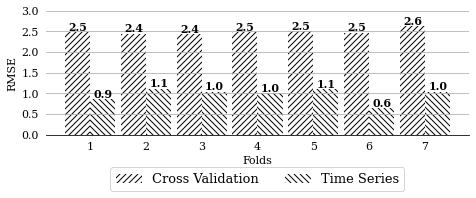

In [11]:
plot_error_scores(error_scores, best_score)